In [1]:
!pip install category_encoders
!pip install catboost
# !pip uninstall scikit-learn imbalanced-learn
# !pip install scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [2]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from category_encoders import TargetEncoder

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler


# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Business Problem Understanding

**Context**

Suatu perusahaan yang bergerak di bidang asuransi perjalanan ingin mengetahui pemegang polis yang akan mengajukan klaim asuransi untuk pertanggungan. Data pemegang polis pada perusahaan asuransi merupakan data historis yang terdiri dari destinasi, produk asuransi, dan sebagainya.

Target :

- 0 : Tidak mengajukan klaim asuransi

- 1 : Mengajukan klaim asuransi

Problem Statement :

- Perusahaan ingin mengetahui customer mana saja yang akan mengajukan klaim asuransi untuk pertanggungan

Goals :

- Maka berdasarkan permasalahan tersebut, perusahaan ingin memiliki kemampuan untuk memprediksi customer yang akan mengajukan klaim asuransi atau tidak, sehingga dapat mempersiapkan dana yang dibutuhkan perusahaan tersebut.

- Dan juga perusahaan ingin mengetahui apa/faktor/variabel apa yang membuat customer biasanya melakukan klaim asuransi atau tidak, sehingga perusahaan dapat melakukan persiapan dana untuk pencairan asuransi.

Analytic Approach :

- Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan customer mana yang biasanya akan melakukan klaim asuransi dan yang tidak.

- Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas customer yang akan melakukan klaim asuransi atau tidak.

Metric Evaluation

- Kita ingin membuat model yang dapat memprediksi customer mana yang akan melakukan claim asuransi.

Jadi nanti metric utama yang akan kita gunakan adalah roc_auc

## Data Understanding

In [3]:
df = pd.read_csv('data_travel_insurance.csv')
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


### Penjelasan setiap variable (Data Dictionary)

Keterangan Kolom Dataset :

- Agency : Nama agensi asuransi perjalanan
- Agency Type : Jenis agensi asuransi perjalanan (airlines/penerbangan atau travel agency)
- Distribution Channel : Saluran distribusi agensi (online / offline)
- Product Name : Nama produk asuransi perjalanan yang dibeli pemegang polis
- Gender : jenis kelamin pemegang polis
- Duration : Durasi perjalanan (hari)
- Destination : Tujuan perjalanan
- Net Sales : Total penjualan bersih asuransi perjalanan (jumlah penjualan kotor perusahaan dikurangi retur, tunjangan, dan diskon)
- Commission (in value) : Komisi yang diterima agensi asuransi perjalanan dari perusahaan asuransi
- Age : Usia pemegang polis
- Claim : Status klaim asuransi pemegang polis

### Missing Values

In [4]:
# Agar lebih "cantik" dibuat dataframe
missing = pd.DataFrame({'jumlah':df.isnull().sum().sort_values(ascending = False)})
missing

,jumlah
Gender,31647
Agency,0
Agency Type,0
Distribution Channel,0
Product Name,0
Duration,0
Destination,0
Net Sales,0
Commision (in value),0
Age,0


In [5]:
total_baris_data = len(df)
missing['persentase %'] = round((missing['jumlah']/total_baris_data)*100,2)
missing

,jumlah,persentase %
Gender,31647,71.39
Agency,0,0.00
Agency Type,0,0.00
Distribution Channel,0,0.00
Product Name,0,0.00
Duration,0,0.00
Destination,0,0.00
Net Sales,0,0.00
Commision (in value),0,0.00
Age,0,0.00


<Axes: >

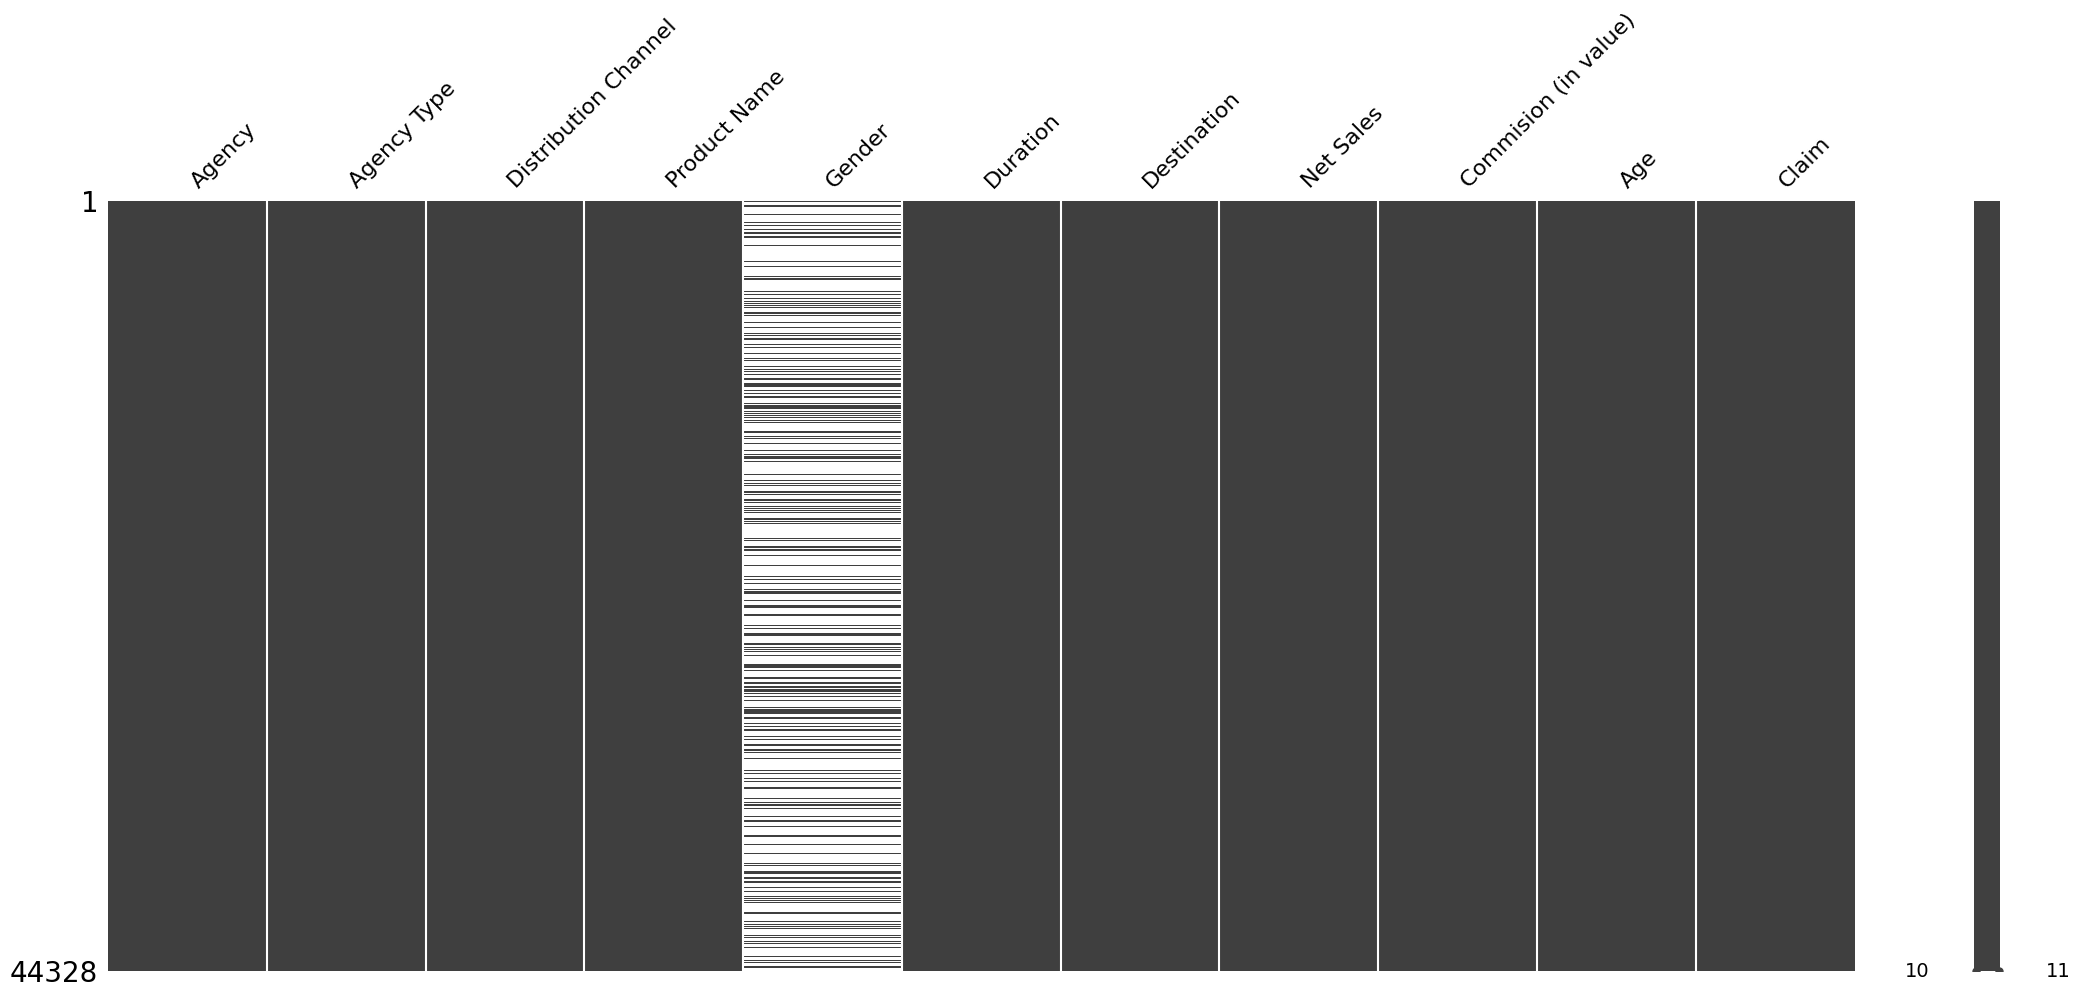

In [6]:
import missingno

# Hubungan antar missing values secara visualisasi
missingno.matrix(df)

### Data Duplikat

In [7]:
# jumlah yang duplikat
df.duplicated().sum()

4667

In [8]:
# mendrop data dupliat
df.drop_duplicates(inplace = True)

### Variable Numerik

#### Statistika Deskriptif

In [9]:
# Statistika dekriptif
df.describe() # OTOMATIS hanya mengambil yang numerik

,Duration,Net Sales,Commision (in value),Age
count,39661.000000,39661.000000,39661.000000,39661.000000
mean,52.397822,42.342794,10.442622,39.930284
std,113.542824,50.025244,20.355921,13.526346
min,-1.000000,-357.500000,0.000000,0.000000
25%,11.000000,19.000000,0.000000,34.000000
50%,25.000000,29.000000,0.000000,36.000000
75%,57.000000,50.000000,11.880000,45.000000
max,4881.000000,810.000000,283.500000,118.000000


#### Distribusi Data

In [10]:
len(df.select_dtypes(include = 'number').columns)

4

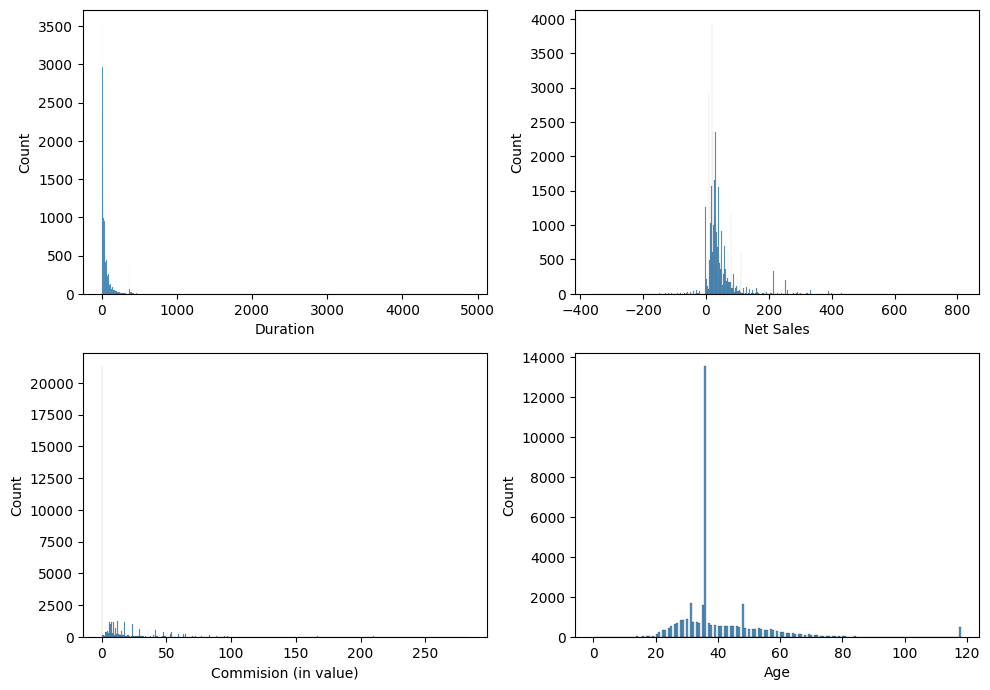

In [11]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(3,2,posisi)
    sns.histplot(df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

#### Outliers

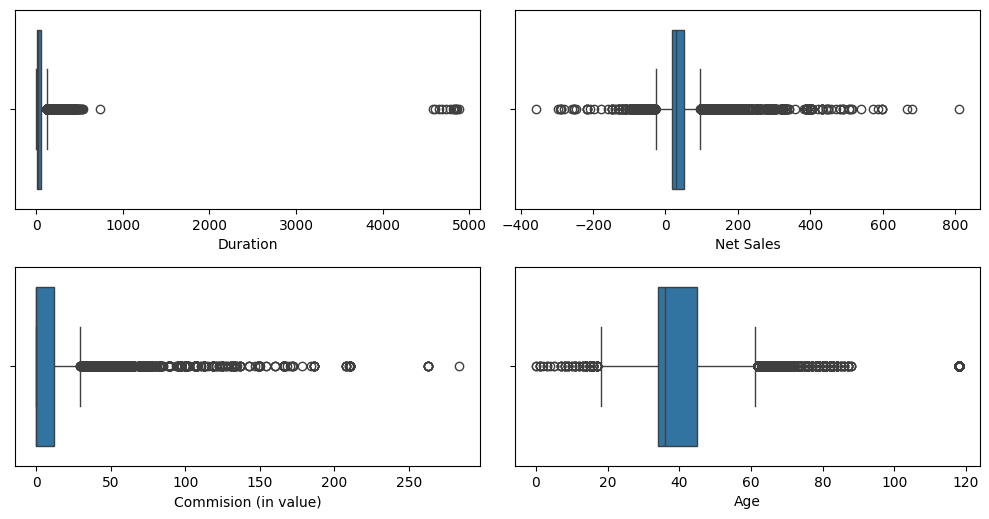

In [12]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

#### Korelasi

<Axes: >

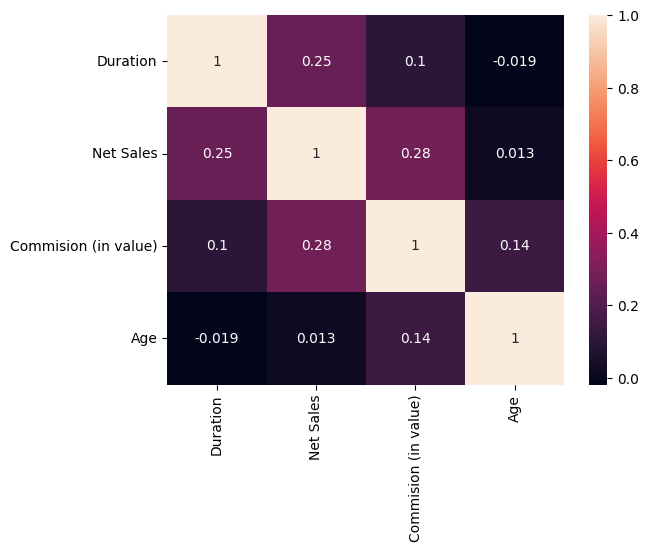

In [13]:
sns.heatmap(numerik.corr(method = 'spearman'), annot = True)

#### Multikolineartias dengan VIF

In [14]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'df' is your DataFrame and you want to check multicollinearity for numerical features
numerical_features = df.select_dtypes(include=np.number).columns
X = df[numerical_features]

# Calculate VIF for each numerical feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Display the VIF values
vif_data

,feature,VIF
0,Duration,1.416778
1,Net Sales,2.944573
2,Commision (in value),2.153112
3,Age,1.646947


### Variabel Kategorik

#### Describe

In [15]:
df.describe(include = 'object')

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,39661,39661,39661,39661,11994,39661,39661
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,20990,28137,38930,11009,6074,8265,38986


#### Unique Values

In [16]:
# Check unique in each variable
pd.set_option('display.max_colwidth', None)

item = []
for i in df.columns :
    item.append([i, df[i].nunique(), df[i].unique()])

table_unique = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                            data = item)
table_unique

,Column Name,Number of Unique,Unique Sample
0,Agency,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, KML, TST, TTW, JWT, ADM, CCR, CBH]"
1,Agency Type,2,"[Airlines, Travel Agency]"
2,Distribution Channel,2,"[Online, Offline]"
3,Product Name,26,"[Annual Silver Plan, Cancellation Plan, Basic Plan, 2 way Comprehensive Plan, Bronze Plan, 1 way Comprehensive Plan, Rental Vehicle Excess Insurance, Single Trip Travel Protect Gold, Silver Plan, Value Plan, 24 Protect, Annual Travel Protect Gold, Comprehensive Plan, Ticket Protector, Travel Cruise Protect, Single Trip Travel Protect Silver, Individual Comprehensive Plan, Gold Plan, Annual Gold Plan, Child Comprehensive Plan, Premier Plan, Annual Travel Protect Silver, Single Trip Travel Protect Platinum, Annual Travel Protect Platinum, Spouse or Parents Comprehensive Plan, Travel Cruise Protect Family]"
4,Gender,2,"[F, nan, M]"
5,Duration,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 376, 6, 16, 27, 34, 3, 14, 12, 31, 5, 7, 56, 29, 30, 58, 9, 38, 42, 11, 13, 40, 79, 370, 366, 26, 83, 55, 18, 100, 1, 35, 36, 75, 23, 73, 32, 232, 37, 10, 4736, 15, 17, 99, 173, 74, 82, 66, 156, 39, 95, 98, 111, 430, 53, 77, 87, 70, 151, 45, 54, 114, 118, 62, 28, 112, 326, 22, 59, 44, 21, 97, 63, 60, 51, 180, 160, 368, 65, 93, 71, 57, 0, 76, 69, 110, 146, 116, 129, 84, ...]"
6,Destination,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KOREA, REPUBLIC OF, THAILAND, GERMANY, JAPAN, INDONESIA, VIET NAM, AUSTRALIA, FINLAND, UNITED KINGDOM, SRI LANKA, SPAIN, HONG KONG, MACAO, CHINA, UNITED ARAB EMIRATES, IRAN, ISLAMIC REPUBLIC OF, TAIWAN, PROVINCE OF CHINA, POLAND, CANADA, OMAN, PHILIPPINES, GREECE, BELGIUM, TURKEY, BRUNEI DARUSSALAM, DENMARK, SWITZERLAND, NETHERLANDS, SWEDEN, MYANMAR, KENYA, CZECH REPUBLIC, FRANCE, RUSSIAN FEDERATION, PAKISTAN, ARGENTINA, TANZANIA, UNITED REPUBLIC OF, SERBIA, ITALY, CROATIA, NEW ZEALAND, PERU, MONGOLIA, CAMBODIA, QATAR, NORWAY, LUXEMBOURG, MALTA, LAO PEOPLE'S DEMOCRATIC REPUBLIC, ISRAEL, SAUDI ARABIA, AUSTRIA, PORTUGAL, NEPAL, UKRAINE, ESTONIA, ICELAND, BRAZIL, MEXICO, CAYMAN ISLANDS, PANAMA, BANGLADESH, TURKMENISTAN, BAHRAIN, KAZAKHSTAN, TUNISIA, IRELAND, ETHIOPIA, NORTHERN MARIANA ISLANDS, MALDIVES, SOUTH AFRICA, VENEZUELA, COSTA RICA, JORDAN, MALI, CYPRUS, MAURITIUS, LEBANON, KUWAIT, AZERBAIJAN, HUNGARY, BHUTAN, BELARUS, MOROCCO, ECUADOR, UZBEKISTAN, CHILE, FIJI, PAPUA NEW GUINEA, ANGOLA, FRENCH POLYNESIA, NIGERIA, MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF, NAMIBIA, GEORGIA, COLOMBIA, ...]"
7,Net Sales,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 80.0, 40.0, 26.0, 252.85, 47.0, 25.0, 23.0, 20.0, 30.0, 42.0, 56.0, 19.8, 14.0, 29.7, 36.0, 31.0, 58.0, 9.9, 15.0, 21.0, 29.0, 32.0, 125.0, 48.0, 0.0, 21.04, 33.0, 204.6, 34.0, 30.55, 35.0, 49.5, 18.0, 98.0, 77.0, 69.3, 64.0, 0.32, 227.7, 48.5, -216.75, 24.0, 161.0, 99.0, 59.4, 45.0, 37.0, 44.0, 19.0, 75.0, 39.0, 17.55, -59.4, 51.0, -29.7, 80.25, 63.0, 12.0, 72.0, 53.0, 38.0, 17.0, 54.0, 69.0, 115.0, 76.3, 19.5, 29.5, 62.0, 11.0, 3.73, 79.0, 138.6, 22.5, 59.0, 5.59, 33.5, 53.25, 62.25, 93.0, -12.0, 1.03, 27.0, 56.5, 39.6, 28.0, 41.0, 97.0, 128.0, 43.0, 66.0, 26.5, 0.19, ...]"
8,Commision (in value),915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88, 17.82, 23.4, 7.5, 5.94, 43.75, 23.76, 7.36, 132.99, 9.57, 7.64, 12.25, 29.7, 6.3, 5.63, 41.58, 5.25, 0.09, 6.0, 136.62, 31.53, 54.19, 11.55, 10.15, 40.25, 59.4, 35.64, 15.75, 12.95, 28.5, 9.75, 4.39, 20.06, 18.0, 4.25, 19.07, 4.88, 7.38, 15.5, 1.05, 83.16, 14.7, 15.4, 1.57, 8.38, 13.31, 15.56, 0.29, 8.0, 36.73, 13.65, 20.3, 5.0, 10.0, 6.63, 0.05, 24.15, 29.05, 8.88, 14.0, 3.38, 15.88, 0.45, 10.89, 47.52, 0.37, 27.25, 18.13, 15.6, 70.2, 12.4, 72.94, 8.63, 4.63, 6.75, 11.25, 0.96, 53.46, 77.22, 1.13, 4.94, 1.73, 10.38, 58.45, 23.5, 6.94, 6.13, 41.42, 17.5, 13.16, 0.14, 3.23, 15.93, ...]"
9,Age,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 51, 65, 47, 35, 54, 23, 46, 58, 42, 31, 29, 37, 68, 8, 32, 61, 49, 56, 25, 50, 34, 38, 44, 118, 45, 53, 20, 30, 41, 69, 52, 40, 70, 76,

## Data Cleaning

In [17]:
total_baris_data = len(df)
missing['persentase %'] = round((missing['jumlah']/total_baris_data)*100,2)
missing

,jumlah,persentase %
Gender,31647,79.79
Agency,0,0.00
Agency Type,0,0.00
Distribution Channel,0,0.00
Product Name,0,0.00
Duration,0,0.00
Destination,0,0.00
Net Sales,0,0.00
Commision (in value),0,0.00
Age,0,0.00


Persentase missing value pada kolom gender terlalu besar yaitu 71.39% sehingga akan sulit untuk mengklasifikasikan pemegang polis yang melakukan klaim/tidak berdasarkan gender.

In [18]:
# Drop gender
df.drop(['Gender'], axis=1, inplace=True)
df.head(1)

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No


####**Pengelompokan Kolom Age**

Pada kolom Age terdapat error data, dimana age yang diinputkan ada yang melebihi 110 tahun terdapat sebanyak 676 data (kita asumsikan sebagai lansia)

Kita akan membuat kolom baru bernama Group_Age untuk mengelompokan usia customer

Pengelompokan usia menurut Permenkes No 25. Tahun 2019 :

- Usia Anak : 0 - 10 thn
- Usia Remaja : 10 - 19 thn
- Usia Dewasa : 19 - 44 thn
- Usia Pra Lanjut Usia : 45 - 59 thn
- Usia Lansia : >=60 thn

Source : https://gaya.tempo.co/read/1724197/kategori-umur-balita-remaja-dan-dewasa-menurut-kemenkes-jangan-salah#:~:text=Klasifikasi%20Usia%20Menurut%20WHO&text=%2D%20Usia%20muda%3A%2025%2D44,pikun%3A%2075%2D90%20tahun.

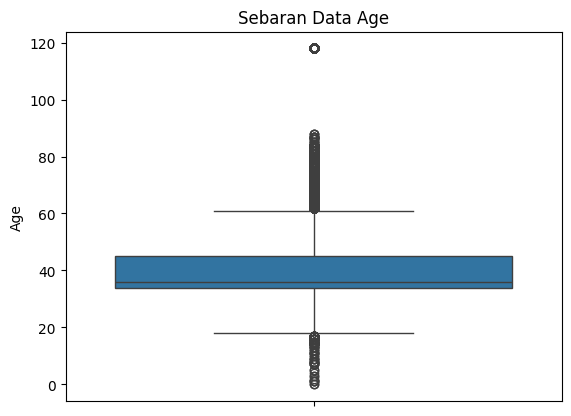

Ditemukan data umur yang melebihi 110 tahun sebanyak 479 data


In [19]:
sns.boxplot(df['Age'])
plt.title("Sebaran Data Age")
plt.show()


print(f"Ditemukan data umur yang melebihi 110 tahun sebanyak {df[df['Age']>=110]['Age'].count()} data")

In [20]:
#Membuat kolom baru Group_Age
conditions = [df['Age']<=10,df['Age']<=19,df['Age']<=44,df['Age']<=59,df['Age']>59]
result = ['Anak','Remaja','Dewasa','Pra Lanjut Usia','Lansia']

df['Group_Age'] = np.select(conditions,result, default='Error')
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Group_Age
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No,Pra Lanjut Usia
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No,Dewasa
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No,Dewasa
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No,Pra Lanjut Usia
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No,Dewasa
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes,Dewasa
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No,Pra Lanjut Usia
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No,Pra Lanjut Usia
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No,Dewasa


Setelah kita buat kolom Group_Age, kita akan menghapus kolom Age dikarenakan data didalam kolom Age sudah diwakilkan oleh kolom Group_Age

In [21]:
df.drop(['Age'],axis=1, inplace=True)

### Pengelompolan Kolom Duration

Didalam kolom Durasi ditemukan ada 2 data yang nilainya -1.



In [22]:
print(df[df['Duration']<0]['Duration'])

26228   -1
26494   -1
Name: Duration, dtype: int64


Data error -1 pada kolom durasi akan kita ubah menjadi 0 dengan asumsi durasi travel insurance -1 tidak melewati hari atau sama dengan durasi 0.

In [23]:
df['Duration'] = df['Duration'].replace(-1,0)

print(df.iloc[26228]['Duration'])
print(df.iloc[26494]['Duration'])


9
5


Didalam kolom Durasi ditemukan ada 13 data yang besar lebih dari 4500 days. Kita asumsikan 13 data ini kemungkinan adalah kesalahan input, dan akan kita hapus.

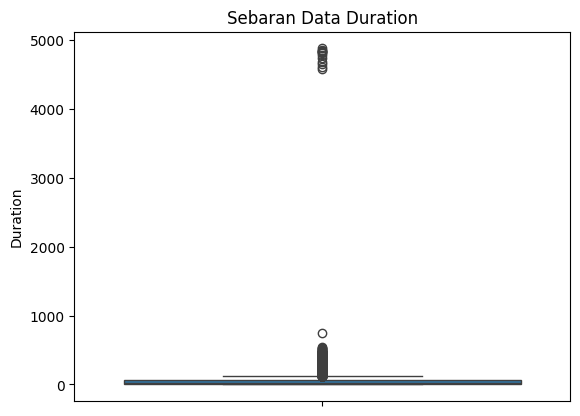

Ditemukan data Duration yang melebihi 4500 days sebanyak 13 data


In [24]:
sns.boxplot(df['Duration'])
plt.title("Sebaran Data Duration")
plt.show()

print(f"Ditemukan data Duration yang melebihi 4500 days sebanyak {df[df['Duration']>=4500]['Duration'].count()} data")

df = df.drop(df[df['Duration'] > 4500].index)


### Group Duration

Kita juga akan membuat kolom baru bernama Group_Duration untuk mengelompokan durasi travel agar mempermudah dalam melakukan analisa

Pengelompokan durasi travel sebagai berikut :

- 1-3 month : 0 - 90 days
- 4-6 month : 91 - 180 days
- 7-9 month : 181 - 270 days
- 10-12 month : 271 - 360 days
- '>12 month : >361 days

In [25]:
#Membuat kolom baru Group Duration
conditions = [df['Duration']<=90,df['Duration']<=180,df['Duration']<=270,df['Duration']<=360,df['Duration']>360]
result = ['1-3 month','4-6 month','7-9 month','10-12 month','>12 month']

df['Group_Duration'] = np.select(conditions,result, default='Error')
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Claim,Group_Age,Group_Duration
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,No,Pra Lanjut Usia,>12 month
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,No,Dewasa,1-3 month
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,No,Dewasa,1-3 month
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,No,Pra Lanjut Usia,1-3 month
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,No,Dewasa,1-3 month
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,Yes,Dewasa,1-3 month
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,No,Pra Lanjut Usia,1-3 month
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,No,Pra Lanjut Usia,1-3 month
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,No,Dewasa,1-3 month


Setelah kita buat kolom Group_Duration, kita akan menghapus kolom Duration dikarenakan data didalam kolom Duration sudah diwakilkan oleh kolom Group_Duration

In [26]:
df.drop(['Duration'],axis=1, inplace=True)

### Pembersihan kolom Net Sales

Terdapat 10 data Net Sales < 0, kemungkinan ini adalah kesalahan input Jadi akan kita hapus ke 10 data ini.

In [27]:
print(df[df['Net Sales']<0])
df = df.drop(df[df['Net Sales'] < 0].index)

      Agency    Agency Type Distribution Channel  \
94       C2B       Airlines               Online   
116      CWT  Travel Agency               Online   
121      CWT  Travel Agency               Online   
199      EPX  Travel Agency               Online   
241      CWT  Travel Agency               Online   
...      ...            ...                  ...   
43694    EPX  Travel Agency               Online   
43743    CWT  Travel Agency               Online   
43751    EPX  Travel Agency               Online   
43858    EPX  Travel Agency               Online   
43922    CWT  Travel Agency               Online   

                          Product Name     Destination  Net Sales  \
94                  Annual Silver Plan       SINGAPORE    -216.75   
116    Rental Vehicle Excess Insurance       AUSTRALIA     -59.40   
121    Rental Vehicle Excess Insurance           JAPAN     -29.70   
199                  Cancellation Plan       HONG KONG     -12.00   
241    Rental Vehicle Excess I

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39170 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                39170 non-null  object 
 1   Agency Type           39170 non-null  object 
 2   Distribution Channel  39170 non-null  object 
 3   Product Name          39170 non-null  object 
 4   Destination           39170 non-null  object 
 5   Net Sales             39170 non-null  float64
 6   Commision (in value)  39170 non-null  float64
 7   Claim                 39170 non-null  object 
 8   Group_Age             39170 non-null  object 
 9   Group_Duration        39170 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.3+ MB


## Data Analysis

In [29]:
#Sorting Data Frame Berdasarkan Group Age dan Group Duration
custom_order_duration = {'1-3 month': 1, '4-6 month': 2, '7-9 month': 3, '10-12 month': 4, '>12 month': 5}
custom_order_age = {'Anak': 1, 'Remaja': 2, 'Dewasa': 3, 'Pra Lanjut Usia': 4, 'Lansia': 5}

grouped = df.groupby(['Group_Duration', 'Group_Age'])

df['Custom_Group_Duration'] = df['Group_Duration'].map(custom_order_duration)
df['Custom_Group_Age'] = df['Group_Age'].map(custom_order_age)
df_sorted = df.sort_values(by=['Custom_Group_Duration', 'Custom_Group_Age'])
df = df_sorted.reset_index(drop = True)
df.drop(['Custom_Group_Duration','Custom_Group_Age'],axis=1, inplace=True)
df

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Net Sales,Commision (in value),Claim,Group_Age,Group_Duration
0,CSR,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
1,C2B,Airlines,Online,Bronze Plan,SINGAPORE,39.00,9.75,No,Anak,1-3 month
2,C2B,Airlines,Online,Silver Plan,SINGAPORE,27.75,6.94,No,Anak,1-3 month
3,CBH,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
4,C2B,Airlines,Online,Bronze Plan,SINGAPORE,20.00,5.00,No,Anak,1-3 month
...,...,...,...,...,...,...,...,...,...,...
39165,C2B,Airlines,Online,Annual Silver Plan,SINGAPORE,216.00,54.00,No,Lansia,>12 month
39166,C2B,Airlines,Online,Annual Silver Plan,SINGAPORE,216.75,54.19,No,Lansia,>12 month
39167,C2B,Airlines,Online,Annual Gold Plan,SINGAPORE,278.85,69.71,No,Lansia,>12 month
39168,LWC,Travel Agency,Online,Annual Travel Protect Silver,UNITED STATES,229.80,149.37,No,Lansia,>12 month


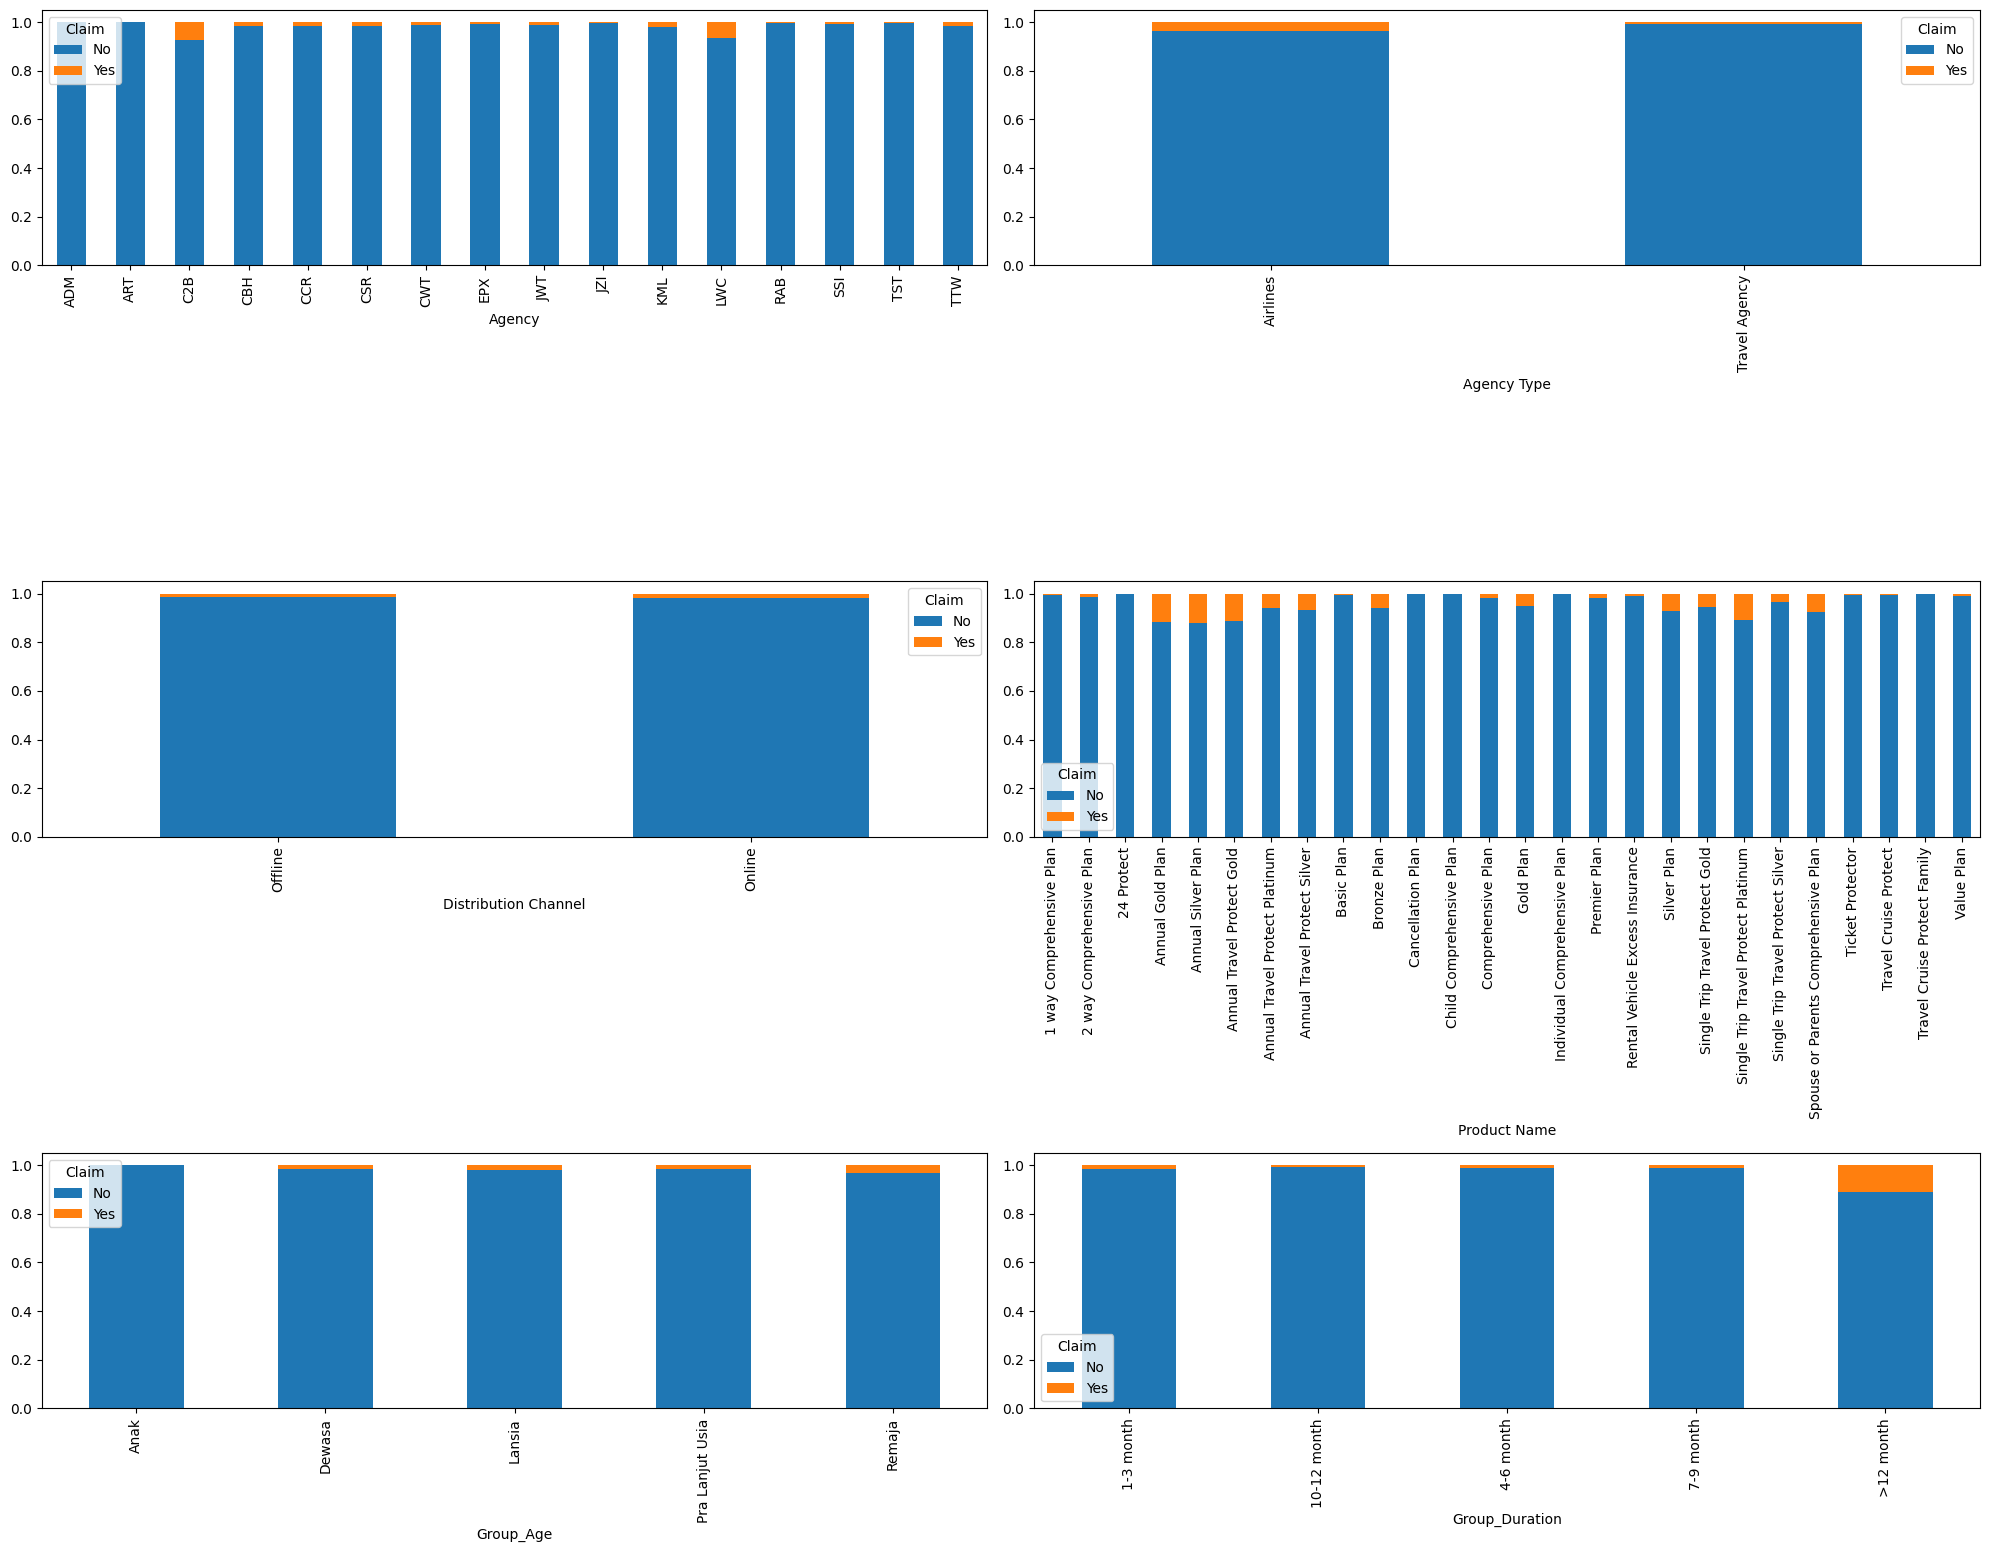

In [30]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['Destination','Net Sales','Commision (in value)','Claim']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['Claim'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()


Berdasarkan diagram Barplot diatas kita dapat melihat adanya perbedaan yang cukup signifikan di diagram Agency, Product Name dan Group_Duration, khususnya pada kelompok >12 month

In [31]:
for i in df.drop(columns=['Destination','Net Sales','Commision (in value)','Claim']).columns:
    relevent_claim_df = df.groupby(i)['Claim'].value_counts(normalize=True).unstack()
    display(relevent_claim_df.sort_values(by=['Yes'], ascending=False))

Claim,No,Yes
Agency,,
C2B,0.925878,0.074122
LWC,0.935412,0.064588
KML,0.979839,0.020161
CCR,0.983051,0.016949
TTW,0.984848,0.015152
CSR,0.985294,0.014706
CBH,0.985507,0.014493
JWT,0.987952,0.012048
CWT,0.988274,0.011726


Claim,No,Yes
Agency Type,,
Airlines,0.961841,0.038159
Travel Agency,0.991414,0.008586


Claim,No,Yes
Distribution Channel,,
Online,0.982728,0.017272
Offline,0.984869,0.015131


Claim,No,Yes
Product Name,,
Annual Silver Plan,0.878378,0.121622
Annual Gold Plan,0.883212,0.116788
Annual Travel Protect Gold,0.888889,0.111111
Single Trip Travel Protect Platinum,0.893617,0.106383
Spouse or Parents Comprehensive Plan,0.923077,0.076923
Silver Plan,0.927856,0.072144
Annual Travel Protect Silver,0.932203,0.067797
Bronze Plan,0.940547,0.059453
Annual Travel Protect Platinum,0.941176,0.058824


Claim,No,Yes
Group_Age,,
Remaja,0.967105,0.032895
Lansia,0.981189,0.018811
Dewasa,0.982769,0.017231
Pra Lanjut Usia,0.983618,0.016382
Anak,1.000000,NaN


Claim,No,Yes
Group_Duration,,
>12 month,0.889600,0.110400
1-3 month,0.985545,0.014455
7-9 month,0.987755,0.012245
4-6 month,0.988029,0.011971
10-12 month,0.994012,0.005988


Berdasarkan barplot dan table diatas kita dapat menyimpulkan beberapa hal:

1. Customer yang melakukan Claim Asuransi paling banyak dari Agency C2B, meskipun secara persentase masih terbilang kecil.
2. Customer yang melakukan Claim Asuransi lebih banyak dari Airlines di banding Travel Agency
3. Customer yang melakukan Claim Asuransi lebih banyak menggunakan Distribution Channel Online di banding Offline, meskipun terpaut sedikit
Produk Asuransi Annual Gold Plan, Annual Silver dan Annual Travel Protect Gold adalah 3
4. produk teratas yang paling sering dilakukan claim asuransi oleh customer
5. Group Age Remaja paling sering melakukan Claim Asuransi dibanding Group Age yang lain
6. Customer yang memiliki Group Duration Travel >12 month paling sering melakukan claim dibanding Group Duration yang lain.

In [32]:
relevent_destination_df = df.groupby('Destination')['Claim'].value_counts(normalize=True).unstack()
relevent_destination_df['count'] = df.groupby('Destination')['Claim'].count()
display(relevent_destination_df.sort_values(by=['Yes'], ascending=False).head(15))
# display(relevent_destination_df.sort_values(by=['Yes'], ascending=False).tail(15))


Claim,No,Yes,count
Destination,,,
COSTA RICA,0.666667,0.333333,3
SINGAPORE,0.949384,0.050616,8199
CZECH REPUBLIC,0.953488,0.046512,43
ICELAND,0.958904,0.041096,73
ISRAEL,0.968750,0.031250,32
ITALY,0.979866,0.020134,298
TURKEY,0.980000,0.020000,50
FRANCE,0.981132,0.018868,318
SOUTH AFRICA,0.981308,0.018692,107


Terlihat dari table diatas, bahwa ada perbedaan kecenderungan claim antara tujuan destinasi negara yang berbeda.

Mari kita lihat kecenderungan 4 tujuan destinasi negara dengan jumlah customer terbanyak.

In [33]:
df['Destination'].value_counts()

,count
Destination,
SINGAPORE,8199
THAILAND,3658
MALAYSIA,3161
CHINA,2925
AUSTRALIA,2370
...,...
JAMAICA,1
CAYMAN ISLANDS,1
URUGUAY,1


In [34]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['SINGAPORE']

,SINGAPORE
Claim,
No,0.949384
Yes,0.050616
count,8199.000000


In [35]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['MALAYSIA']


,MALAYSIA
Claim,
No,0.994938
Yes,0.005062
count,3161.000000


In [36]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['THAILAND']

,THAILAND
Claim,
No,0.993439
Yes,0.006561
count,3658.000000


In [37]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['CHINA']


,CHINA
Claim,
No,0.988718
Yes,0.011282
count,2925.000000


Terlihat bahwa destinasi MALAYSIA,THAILAND, dan CHINA memiliki kecenderungan customer yang sedikit melakukan claim asuransi , sedangkan untuk destinasi SINGAPORE lebih banyak customer yang melakukan claim asuransi.

Sekarang mari kita siapkan data kita untuk pembuatan model machine learning

## Data Preparation

### Encoding

In [38]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Net Sales,Commision (in value),Claim,Group_Age,Group_Duration
0,CSR,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
1,C2B,Airlines,Online,Bronze Plan,SINGAPORE,39.00,9.75,No,Anak,1-3 month
2,C2B,Airlines,Online,Silver Plan,SINGAPORE,27.75,6.94,No,Anak,1-3 month
3,CBH,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
4,C2B,Airlines,Online,Bronze Plan,SINGAPORE,20.00,5.00,No,Anak,1-3 month


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki. Yang akan kita lakukan adalah :

1. Merubah fitur/kolom Agency menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur yang terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/ kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
2. Merubah fitur/kolom Agency Type menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. Merubah fitur/kolom Distribution Channel menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom Product Name menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur yang terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/ kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
5. Merubah fitur/kolom Destination menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur yang terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/ kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
6. Merubah fitur/kolom Group_Age menjadi integer 0-4 dengan Ordinal Encoding, karena fitur ini adalah grouping usia customer, dimana terdapat group usia anak hingga lansia.
7. Merubah fitur/kolom Group_Duration menjadi integer 0-4 dengan Ordinal Encoding, karena fitur ini adalah grouping durasi travel, dimana terdapat group durasi 1-3 month hingga lebih dari 12 month

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39170 entries, 0 to 39169
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                39170 non-null  object 
 1   Agency Type           39170 non-null  object 
 2   Distribution Channel  39170 non-null  object 
 3   Product Name          39170 non-null  object 
 4   Destination           39170 non-null  object 
 5   Net Sales             39170 non-null  float64
 6   Commision (in value)  39170 non-null  float64
 7   Claim                 39170 non-null  object 
 8   Group_Age             39170 non-null  object 
 9   Group_Duration        39170 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.0+ MB


In [40]:
# Ordinal Mapping
ordinal_mapping = [
    {'col': 'Group_Age', 'mapping': {'Anak': 0, 'Remaja': 1, 'Dewasa': 2, 'Pra Lanjut Usia': 3, 'Lansia': 4}},
    {'col': 'Group_Duration', 'mapping': {'1-3 month': 0, '4-6 month': 1, '7-9 month': 2, '10-12 month': 3, '>12 month': 4}}
]


In [41]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['Agency Type','Distribution Channel']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['Group_Age','Group_Duration']),
    ('binary', ce.BinaryEncoder(), ['Destination','Product Name','Agency'])
], remainder='passthrough')



In [42]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(drop='first'),
                                 ['Agency Type', 'Distribution Channel']),
                                ('ordinal',
                                 OrdinalEncoder(mapping=[{'col': 'Group_Age',
                                                          'data_type': dtype('O'),
                                                          'mapping': Anak               0
Remaja             1
Dewasa             2
Pra Lanjut Usia    3
Lansia             4
dtype: int64},
                                                         {'col': 'Group_Duration',
                                                          'data_type': dtype('O'),
                                                          'mapping': 1-3 month      0
4-6 month      1
7-9 month      2
10-12 month    3
>12 month      4
dtype: int64}]),
                                 ['Group_Age', 'Group_Duration']),
                                ('binary', BinaryEncoder(),
                                 ['Destination', 'Product Name', 'Agency'])])

In [43]:
x = df.drop(columns=['Claim']).reset_index(drop=True)
y = df['Claim'].reset_index(drop=True)

In [44]:
#Encoder kolom y menjadi 0 & 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Membuat Series dari array NumPy
y = pd.Series(y)
y = y.reset_index(drop=True)

In [45]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3,random_state=23)

# Reset index pada data dan target
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


## Modeling & Evaluation

In [46]:
logreg = LogisticRegression(random_state=23)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=23)
rf = RandomForestClassifier(random_state=23)
xgb = XGBClassifier(random_state=23)
lgbm = lgb.LGBMClassifier(random_state=23)
gnb = GaussianNB()
cat = CatBoostClassifier(random_state=23)

In [47]:
models = [logreg,knn,dt,rf,xgb,lgbm,gnb,cat]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','GaussianNB','CatBoost'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Output streaming akan dipotong hingga 5000 baris terakhir.
4:	learn: 0.3814472	total: 88.4ms	remaining: 17.6s
5:	learn: 0.3415045	total: 96.1ms	remaining: 15.9s
6:	learn: 0.3078459	total: 106ms	remaining: 15.1s
7:	learn: 0.2793790	total: 117ms	remaining: 14.5s
8:	learn: 0.2523285	total: 125ms	remaining: 13.7s
9:	learn: 0.2316570	total: 132ms	remaining: 13.1s
10:	learn: 0.2127861	total: 140ms	remaining: 12.6s
11:	learn: 0.1983724	total: 145ms	remaining: 11.9s
12:	learn: 0.1843583	total: 150ms	remaining: 11.4s
13:	learn: 0.1710777	total: 158ms	remaining: 11.1s
14:	learn: 0.1606712	total: 165ms	remaining: 10.8s
15:	learn: 0.1509818	total: 173ms	remaining: 10.6s
16:	learn: 0.1418984	total: 180ms	remaining: 10.4s
17:	learn: 0.1342514	total: 189ms	remaining: 10.3s
18:	learn: 0.1279192	total: 202ms	remaining: 10.4s
19:	learn: 0.1224487	total: 210ms	remaining: 10.3s
20:	learn: 0.1179994	total: 217ms	remaining: 10.1s
21:	learn: 0.1131860	total: 226ms	remaining: 10s
22:	learn: 0.1090177	total: 2

,mean roc_auc,sdev
model,,
CatBoost,0.791911,0.032410
Logistic Regression,0.788468,0.042536
LightGBM,0.780957,0.035623
XGBoost,0.777270,0.030235
GaussianNB,0.746376,0.040984
Random Forest,0.687612,0.022446
Decision Tree,0.651630,0.021224
KNN,0.611717,0.021180


Terlihat bahwa model CatBoost adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter. LightGBM, XGBoost dan Logistic Regression juga memiliki hasil yang baik hampir sama dengan CatBoost

## Test Data

In [48]:
models = [logreg,knn,dt,rf,xgb,lgbm,gnb,cat]
score_roc_auc = []

print(x_train)
print(x_test)

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test


    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM','GaussianNB','CatBoost']):
    estimator,y_pred,x_test_prep_scaled = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test_prep_scaled)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM','GaussianNB','CatBoost'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

      Agency    Agency Type Distribution Channel  \
0        EPX  Travel Agency               Online   
1        EPX  Travel Agency               Online   
2        C2B       Airlines               Online   
3        EPX  Travel Agency               Online   
4        RAB       Airlines               Online   
...      ...            ...                  ...   
27414    EPX  Travel Agency               Online   
27415    EPX  Travel Agency               Online   
27416    CWT  Travel Agency               Online   
27417    EPX  Travel Agency               Online   
27418    EPX  Travel Agency               Online   

                          Product Name        Destination  Net Sales  \
0                    Cancellation Plan           MALAYSIA      17.00   
1                    Cancellation Plan          INDONESIA      10.00   
2                   Annual Silver Plan          SINGAPORE     291.75   
3                    Cancellation Plan      UNITED STATES      80.00   
4              

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     11549
           1       0.00      0.00      0.00       202

    accuracy                           0.98     11751
   macro avg       0.49      0.50      0.50     11751
weighted avg       0.97      0.98      0.97     11751

KNN 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     11549
           1       0.00      0.00      0.00       202

    accuracy                           0.98     11751
   macro avg       0.49      0.50      0.50     11751
weighted avg       0.97      0.98      0.97     11751

Decision Tree 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     11549
           1       0.11      0.02      0.04       202

    accuracy                           0.98     11751
   macro avg       0.55      0.51      0.52     11751
weighted avg       0.97      0

,roc_auc score
model,
CatBoost,0.794149
LightGBM,0.788680
XGBoost,0.777497
Logistic Regression,0.765932
GaussianNB,0.738393
Random Forest,0.682828
Decision Tree,0.645270
KNN,0.608555


Terlihat model CatBoost adalah yang terbaik performanya pada test data. Hal ini lebih penting dikarenakan kinerja pada data uji mencerminkan sejauh mana model mampu mengatasi data yang tidak dikenal.

Mari sekarang kita coba melakukan oversampling untuk model CatBoost kita untuk melihat apakah kita dapat mendapatkan hasil yang lebih baik lagi.

## Test Oversampling with K-Fold Cross Validation

In [49]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    pr_auc = average_precision_score(y_train, predictProba[:, 1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return {
        'report': report,
        'f1' : f1,
        'roc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    pr_auc = average_precision_score(y_test, predictProba[:, 1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return {
        'report': report,
        'f1' : f1,
        'roc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [50]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)


In [51]:
x_train_encoded = transformer.fit_transform(x_train,y_train)
x_test_encoded = transformer.transform(x_test)

data = x_train_encoded
target = y_train

In [52]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []


train_errors_smote = []
validation_errors_smote = []

train_errors_with_undersampling = []
validation_errors_with_undersampling = []

threshold = 0.20  # Atur threshold di sini

for train_index, val_index in kf.split(data, target):

    X_train, X_val = data[train_index], data[val_index]
    Y_train, Y_val = target[train_index], target[val_index]

    smote = SMOTE(sampling_strategy=0.6, k_neighbors=2, random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, Y_train)

    # rus = RandomUnderSampler(random_state=42,sampling_strategy=0.8)
    # X_rus, y_rus = rus.fit_resample(X_train, Y_train)

    ros = RandomOverSampler()
    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    cat_model = CatBoostClassifier()
    estimator = Pipeline([
    ('model', cat_model)
    ])

    estimator.fit(X_smote, y_smote)

    y_pred_proba = estimator.predict_proba(X_val)[:, 1]

    # Menerapkan threshold yang telah ditentukan
    y_pred = (y_pred_proba >= threshold).astype(int)


    # calculate errors
    # train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, y_pred, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, y_pred, estimator)
    # train_error_smote, val_error_smote = calc_metrics(X_smote,y_smote, X_val, y_pred, estimator)
    # train_error_with_undersampling, val_error_with_undersampling = calc_metrics(X_rus, y_rus, X_val, y_pred, estimator)


    # append to appropriate list
    # train_errors_without_oversampling.append(train_error_without_oversampling)
    # validation_errors_without_oversampling.append(val_error_without_oversampling)

    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

    # train_errors_smote.append(train_error_smote)
    # validation_errors_smote.append(val_error_smote)

    # train_errors_with_undersampling.append(train_error_with_undersampling)
    # validation_errors_with_undersampling.append(val_error_with_undersampling)

Output streaming akan dipotong hingga 5000 baris terakhir.
4:	learn: 0.5929331	total: 69.4ms	remaining: 13.8s
5:	learn: 0.5807676	total: 84.2ms	remaining: 14s
6:	learn: 0.5695779	total: 97.3ms	remaining: 13.8s
7:	learn: 0.5582598	total: 111ms	remaining: 13.8s
8:	learn: 0.5487382	total: 125ms	remaining: 13.7s
9:	learn: 0.5412765	total: 138ms	remaining: 13.6s
10:	learn: 0.5329020	total: 151ms	remaining: 13.6s
11:	learn: 0.5264584	total: 165ms	remaining: 13.5s
12:	learn: 0.5212788	total: 178ms	remaining: 13.5s
13:	learn: 0.5164561	total: 191ms	remaining: 13.4s
14:	learn: 0.5120334	total: 222ms	remaining: 14.6s
15:	learn: 0.5043050	total: 235ms	remaining: 14.5s
16:	learn: 0.4983381	total: 249ms	remaining: 14.4s
17:	learn: 0.4926089	total: 263ms	remaining: 14.4s
18:	learn: 0.4883094	total: 276ms	remaining: 14.3s
19:	learn: 0.4842180	total: 290ms	remaining: 14.2s
20:	learn: 0.4815220	total: 302ms	remaining: 14.1s
21:	learn: 0.4790245	total: 316ms	remaining: 14s
22:	learn: 0.4740061	total: 32

## Evaluation Metrics With Oversampling

In [53]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))

dfEvaluate = pd.DataFrame(listItem,
                    columns=['Train Accuracy',
                            'Test Accuracy',
                            'Train ROC AUC',
                            'Test ROC AUC',
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.918292,0.937272,0.961716,0.975853,0.918062,0.857776,0.971300,0.931900,0.878197,0.629540
1,0.918849,0.931802,0.963114,0.962370,0.918611,0.849266,0.972867,0.897611,0.878010,0.626190
2,0.916230,0.933625,0.961661,0.969748,0.916002,0.854852,0.968331,0.868167,0.876951,0.656934
3,0.918519,0.942743,0.962354,0.978830,0.918283,0.870976,0.972207,0.927835,0.877937,0.665025
4,0.914292,0.942378,0.961532,0.970272,0.914098,0.867043,0.961857,0.872483,0.878304,0.684211
5,0.915674,0.940554,0.962326,0.972336,0.915445,0.863009,0.967671,0.914894,0.876517,0.649874
6,0.916543,0.933260,0.962458,0.974281,0.916324,0.843419,0.967714,0.916350,0.877871,0.599502
7,0.917388,0.940554,0.963283,0.975392,0.917144,0.864039,0.971714,0.915789,0.876483,0.652500
8,0.918873,0.937637,0.962624,0.970796,0.918634,0.866284,0.973074,0.904459,0.877906,0.668235
9,0.913842,0.935060,0.961399,0.974382,0.913609,0.853531,0.965776,0.866221,0.874902,0.652393


Terlihat bahwa hasil evaluation metrics untuk recall maupun precision dari class positive sudah cukup baik saat di oversampling. Noted* Dimana sebelumnya saya sudah mencoba berbagai macam evaluation matrics seperti oversampling, undersampling, smote, borderline-smote, adasyn, without oversampling/undersampling. Hasil yang paling baik diperlihatkan pada saat oversampling.

Tidak semua saya tampilkan, untuk kepentingan user agar lebih mudah membaca hasil analisa, hanya yang terbaik yang saya tampilkan.

Mari sekarang kita lihat juga classification reportsnya.

## Classification Reports With Oversampling


In [54]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2463
           1       0.63      0.93      0.75       279

    accuracy                           0.94      2742
   macro avg       0.81      0.93      0.86      2742
weighted avg       0.95      0.94      0.94      2742

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2449
           1       0.63      0.90      0.74       293

    accuracy                           0.93      2742
   macro avg       0.81      0.92      0.85      2742
weighted avg       0.95      0.93      0.94      2742

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2431
           1       0.66      0.87      0.75       311

    accuracy                           0.93      2742
   macro avg       0.82      0.91      0.85      2742
weighted avg       0.95      0.93      0.94      2742

              preci

Terlihat bahwa model yang setelah di oversampling memiliki recall dari kedua class yang cukup baik. Oleh karena itu untuk kasus kali ini, mari kita gunakan model yang menggunakan oversampling.

Sekarang mari kita coba melakukan hyperparameter tuning pada model CatBoost kita untuk mendapatkan hasil yang lebih baik lagi.

In [64]:
score_roc_auc = [cat_model.score(x_test_encoded, y_test)]
print(score_roc_auc)

[0.855161262871245]


Save Best Model

In [59]:
model = estimator['model']
model.save_model("catboost_best_model.cbm")

print("Model telah disimpan sebagai 'catboost_best_model.cbm'.")

Model telah disimpan sebagai 'catboost_best_model.cbm'.


## Keuntungan Perusahaan

Model kita dapat membaca 82% customer yang tidak melakukan claim asuransi, dan model kita dapat mendapatkan 69% customer yang melakukan claim asuransi. Dikarenakan pencairan asuransi berbeda-beda, tergantung produk yang diambil. Untuk proses perhitungan kita asumsikan, 1x pencairan asuransi biaya yang dikeluarkan oleh perusahaan adalah 100 USD. Anggap saja kita punya 100 customer maka : *Tanpa Model (semua customer kita asumsikan akan melakukan claim asuransi)

Total Dana yang perlu disiapkan => 100 x 100 USD = 10.000 USD *Dengan Model (hanya customer yang diperkirakan melakukan claim asuransi)
Total Dana yang perlu disiapkan => 69 x 100 = 6.900 USD
Berdasarkan contoh hitungan tersebut, terlihat bahwa dengan menggunakan model kita, maka perusahaan tersebut dapat menyimpan dana sebesar 31% untuk keperluan yang lain.

## Hyperparameter Tuning

In [ ]:
#Define CatBoost Classifier
cat_model = CatBoostClassifier(verbose=0)

# Set parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
}

In [ ]:
#Perform Grid Search
# Define the pipeline with the transformer and the model
estimator = Pipeline([
    ('preprocess', transformer),  # Apply the transformer first
    ('model', cat_model)
])

# Now use the pipeline in GridSearchCV
# Access the CatBoostClassifier's parameters using 'model__parameter_name' syntax:
param_grid = {
    'model__iterations': [100, 300, 500],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__l2_leaf_reg': [1, 3, 5],
}


grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5), scoring='roc_auc',
                           verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(x_train,y_train)

In [ ]:
# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [ ]:
# Evaluate the model on the test set
y_pred = best_model.predict(x_test)
y_pred_proba = best_model.predict_proba(x_test)[:, 1]

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Ternyata hasil dari Hyperparameter Tuning model kita tidak lebih baik dari hasil model kita sebelum tuning, maka kita akan tetap menggunakan model sebelum tuning sebagai best model kita

## Feature Importances
Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model CatBoost kita

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Mendapatkan feature importances
feature_importances = best_model['model'].feature_importances_

# Mendapatkan nama fitur
feature_names = best_model['preprocess'].get_feature_names_out()

# Membuat DataFrame untuk feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Mengurutkan feature importances secara descending
feature_importance_df = feature_importance_df.sort_values(by=['importance'], ascending=False)

# Membuat visualisasi bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importances')
plt.gca().invert_yaxis()  # Membalik urutan fitur agar yang paling penting di atas
plt.tight_layout()
plt.show()

Terlihat bahwa ternyata untuk model CatBoost kita, fitur/kolom Net sales adalah yang paling penting, kemudian diikuti dengan Agency, dan selanjutnya.



In [ ]:
confusion_matrix(y_test,y_pred)

sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt='d')

In [ ]:
print('Classification Report Tuned CatBoost: \n', classification_report(y_test, y_pred))

Hasil Model:

1. Label 0:
- Precision: 0.98 Artinya, dari semua prediksi positif untuk kelas 0, 98% di antaranya benar.
- Recall: 1.00 Model berhasil mengidentifikasi semua sampel sebenarnya dari kelas 0.
- F1-Score: 0.99 Kombinasi rata-rata harmonis antara precision dan recall, menunjukkan performa sangat baik untuk kelas ini.
2. Label 1:
- Precision, Recall, F1-Score: 0.00 Model kurang bisa memprediksi kelas 1, menghasilkan skor nol pada semua metrik.

## Conclusion & Recommendation

Conclusion



Hasil model sebelum tuning jauh lebih baik dibandingkan setelah tuning, terutama karena mampu menangani kelas minoritas dengan lebih baik. Setelah tuning, model menjadi bias terhadap kelas mayoritas, meskipun akurasi keseluruhan meningkat.

hal ini akan kita perbaiki di kesempatan berikutnya dengan penambahan kolom/fitur yang lebih berhubungan dengan customer melakukan claim asuransi atau tidak.

Recommendation

- Menambah banyaknya data customer yang melakukan claim asuransi
- Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan claim asuransi, seperti
tanggal claim asuransi (untuk melihat ada atau tidak di bulan2 tertentu berkorelasi dengan banyaknya claim asuransi yang masuk) dan ID Customer (untuk melihat customer yang melakukan claim asuransi apakah new_customer atau customer lama yang sudah berlangganan travel asuransi)
- Menganalisa data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.